# पीटर और भेड़िया: यथार्थवादी वातावरण

हमारी स्थिति में, पीटर लगभग बिना थके या भूखे हुए इधर-उधर घूम सकता था। एक अधिक यथार्थवादी दुनिया में, उसे समय-समय पर बैठकर आराम करना होगा और खुद को खाना खिलाना होगा। चलिए हमारी दुनिया को अधिक यथार्थवादी बनाते हैं, निम्नलिखित नियम लागू करके:

1. एक स्थान से दूसरे स्थान पर जाने से, पीटर की **ऊर्जा** कम होती है और उसे कुछ **थकान** होती है।
2. पीटर सेब खाकर अधिक ऊर्जा प्राप्त कर सकता है।
3. पीटर पेड़ के नीचे या घास पर आराम करके थकान से छुटकारा पा सकता है (यानी बोर्ड के उस स्थान पर जाना जहां पेड़ या घास हो - हरा क्षेत्र)।
4. पीटर को भेड़िया ढूंढकर मारना होगा।
5. भेड़िया को मारने के लिए, पीटर के पास ऊर्जा और थकान के निश्चित स्तर होने चाहिए, अन्यथा वह लड़ाई हार जाएगा।


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

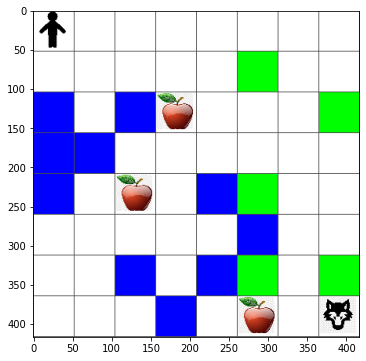

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## स्थिति परिभाषित करना

हमारे नए खेल नियमों में, हमें प्रत्येक बोर्ड स्थिति पर ऊर्जा और थकान का ध्यान रखना होगा। इसलिए, हम एक ऑब्जेक्ट `state` बनाएंगे जो वर्तमान समस्या की स्थिति के बारे में सभी आवश्यक जानकारी रखेगा, जिसमें बोर्ड की स्थिति, ऊर्जा और थकान के वर्तमान स्तर, और यह कि क्या हम टर्मिनल स्थिति में भेड़िये को हरा सकते हैं:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## पुरस्कार फ़ंक्शन

### परिचय
पुरस्कार फ़ंक्शन वह है जो आपके एजेंट को यह तय करने में मदद करता है कि कौन से कार्य अच्छे हैं और कौन से बुरे। यह आपके एजेंट के व्यवहार को आकार देने में एक महत्वपूर्ण भूमिका निभाता है।

### मुख्य विचार
- **स्पष्टता:** पुरस्कार फ़ंक्शन को सरल और स्पष्ट रखें ताकि एजेंट आसानी से समझ सके।
- **संतुलन:** सुनिश्चित करें कि पुरस्कार और दंड संतुलित हैं। बहुत अधिक दंड एजेंट को हतोत्साहित कर सकता है।
- **लक्ष्य-उन्मुख:** पुरस्कार फ़ंक्शन को आपके एजेंट के अंतिम लक्ष्य के साथ संरेखित करें।

### उदाहरण
नीचे एक साधारण पुरस्कार फ़ंक्शन का उदाहरण दिया गया है:

```python
def reward_function(state, action):
    if action == "desired_action":
        return 10  # सकारात्मक पुरस्कार
    else:
        return -5  # नकारात्मक पुरस्कार
```

### सामान्य गलतियाँ
- **अत्यधिक जटिलता:** बहुत जटिल पुरस्कार फ़ंक्शन एजेंट को भ्रमित कर सकता है।
- **असंगतता:** यदि पुरस्कार फ़ंक्शन असंगत है, तो एजेंट अप्रत्याशित व्यवहार प्रदर्शित कर सकता है।
- **लंबे समय तक प्रभाव की अनदेखी:** केवल तात्कालिक पुरस्कार पर ध्यान केंद्रित करना और दीर्घकालिक परिणामों को नज़रअंदाज़ करना।

### सुझाव
[!TIP] पुरस्कार फ़ंक्शन को बार-बार परीक्षण और सुधारें। यह सुनिश्चित करें कि यह आपके एजेंट के प्रदर्शन को बेहतर बनाने में मदद कर रहा है।

### निष्कर्ष
एक अच्छा पुरस्कार फ़ंक्शन आपके एजेंट को सही दिशा में मार्गदर्शन करने में मदद करता है। इसे सरल, संतुलित और लक्ष्य-उन्मुख रखें।


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## क्यू-लर्निंग एल्गोरिथ्म

वास्तविक लर्निंग एल्गोरिथ्म लगभग वैसा ही रहता है, हम केवल बोर्ड स्थिति के बजाय `state` का उपयोग करते हैं।


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

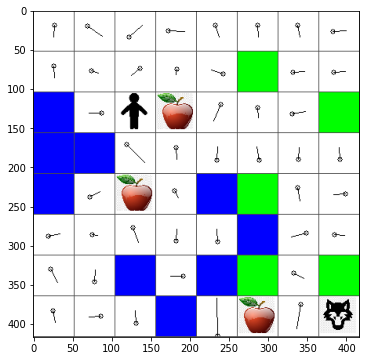

In [11]:
m.plot(Q)

## परिणाम

चलो देखते हैं कि क्या हम पीटर को भेड़िये से लड़ने के लिए सफलतापूर्वक प्रशिक्षित कर पाए!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


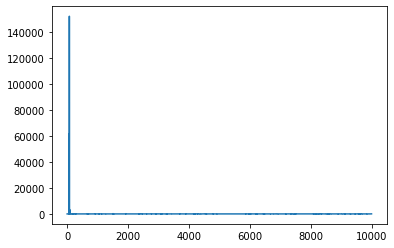

In [13]:
plt.plot(lpath)


---

**अस्वीकरण**:  
यह दस्तावेज़ AI अनुवाद सेवा [Co-op Translator](https://github.com/Azure/co-op-translator) का उपयोग करके अनुवादित किया गया है। जबकि हम सटीकता सुनिश्चित करने का प्रयास करते हैं, कृपया ध्यान दें कि स्वचालित अनुवाद में त्रुटियां या अशुद्धियां हो सकती हैं। मूल भाषा में उपलब्ध मूल दस्तावेज़ को आधिकारिक स्रोत माना जाना चाहिए। महत्वपूर्ण जानकारी के लिए, पेशेवर मानव अनुवाद की सिफारिश की जाती है। इस अनुवाद के उपयोग से उत्पन्न किसी भी गलतफहमी या गलत व्याख्या के लिए हम जिम्मेदार नहीं हैं।
